In [1]:
import gym
from gym import error, spaces, utils
from gym.core import ObservationWrapper
from gym.utils import seeding
import numpy as np
import math


class Kickenv1(gym.Env):
    

    def __init__(self,di :float,vp : float,lenbar :float, wbar:float,model):
        '''Constructor for our environment. Should take any relevant parameters as arguments.

        Parameters
        ----------
        di : float
            diameter of puck
        vp : float
            horizontal velocity of puck
        lenbar : float 
            length of the bar
        wbar : float 
            width of the bar

        Ideal Settings :
        BallDiameter = ScreenWidth / 64;
        BarWidth = Settings.BallDiameter / 2;
        BarLength = ScreenHeight / 6;
        BallStartingPosX = ScreenWidth / 8;
        BallStartingPosY = ScreenHeight / 2;
        BarStartingPosX = 7*ScreenWidth/8;
        BarStartingPosY = BallStartingPosY;
        FinalLine =BarStartingPosX + 3*BarWidth;        
        BallSpeed = ScreenWidth / 100
        '''
        # For simplicity only allow odd number of states.
        self.xi=-0.75
        self.yi=0
        
        self.xib=0.75
        self.yib=0
        self.r=di/2
        self.g=0.77
        self.vbar=0
        self.theta=1
        self.vp=vp
        self.lenbar=lenbar
        self.wbar=wbar    
        self.statep=[self.xi,self.yi]
        self.stateb=[self.xib,self.yib]
        self.timestepcounter=0
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.action_space = spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r,-1+self.lenbar/2,]),high=np.array([1.0-self.r,1.0-self.r,1-(self.lenbar/2),]),shape=(3,))
        self.action_spacep=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.action_spaceb=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_spacep=spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r]),high=np.array([1.0-self.r,1.0-self.r]),shape=(2,))
        self.observation_spaceb=spaces.Box(low=-1+self.lenbar/2,high=1-(self.lenbar/2),shape=(1,))
        self.donep=False
        self.doneb=False
        self.rewardp=0
        self.statepr=self.statep
        self.rewardb=0
        self.model = model
    def step(self,a) :
        '''Defines what to do if an action is taken.

        Parameters
        ----------
        action : list of actions taken by the puck and bar respectively
            Action  taken.  

        Returns
        -------
        tuple[int, float, bool, None]
            A tuple containing the next state, reward obtained, whether terminal state has been reached, and None.
        '''
        """
        """
        if self.donep :return np.array(self.statep+ [self.stateb[1]],dtype = float),self.rewardp,self.donep,{}
        
        action = np.zeros(2)
        action[0] = a
        if isinstance(self.model,int) :action[1] = 0.1
        else: action[1] = self.model.predict(np.array(self.statep+ [self.stateb[1]],dtype = float))[0]
        self.donep=False
        self.doneb=False
        posbar=self.stateb
        self.theta_arr[self.timestepcounter]=action[1]
        action[0]=action[0]*self.vp
        if(self.timestepcounter>=2):
            if action[1]>=0.8:
                if self.theta_arr[self.timestepcounter-1]>=0.8 and self.theta_arr[self.timestepcounter-2]>=0.8 :
                    self.theta=self.theta+0.85
            elif action[1]<=-0.8 :
                if self.theta_arr[self.timestepcounter-1]<=-0.8 and self.theta_arr[self.timestepcounter-2]<=0.8 :
                    self.theta=self.theta+0.85
            else : self.theta=1
        else : self.theta=1            
        vw=self.theta*self.vp*(2/3)
        statebr=self.stateb
        self.stateb[1]=max(self.observation_spaceb.low,min(self.observation_spaceb.high,self.stateb[1]+action[1]*vw))
        self.statepr=self.statep
        self.statep[0]=self.statep[0]+self.vp
        self.statep[1]=max(self.observation_spacep.low[1],min(self.observation_spacep.high[1],self.statep[1]+action[0]))
        self.rewardp=0
        self.rewardb=0
        if abs(self.statep[0]-posbar[0])<=self.r+self.wbar/2 and abs(self.statep[1]-posbar[1])<=self.r+self.lenbar/2 :
            self.rewardp=-1
            self.rewardb=1
            self.donep=True
        if self.statep[0]>=self.xib and self.statepr[0]<=self.xib and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1
            self.statep[0]=self.xib-self.wbar-self.r 
        if self.statep[0]+self.r>=self.g and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1      
        
#         print(self.statep)
#         print(self.stateb[1])
        #print(np.array(self.statep+ [self.stateb[1]],dtype = float))
        #print(self.rewardp)
        return np.array(self.statep+ [self.stateb[1]],dtype = float),self.rewardp,self.donep,{}



    def reset(self):
        '''What to do if we reset the environment.
        '''
        # We simply make our current state equal to initial state .
        # We change the status of completion of our episode[self.done variable] to False.
        # make timestepcounter=0
        #change parameters such a theta and prev_dir to 1 and 0 respectively.
        # Return state and status of completion 
        self.statep =[self.xi,self.yi]
        self.donep=False
        self.doneb=False
        self.stateb=[self.xib,self.yib]
        self.prev_dir=0
        self.theta=1
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.statepr=self.statep
        self.timestepcounter=0
        return np.array(self.statep+ [self.stateb[1]],dtype = float)

In [2]:
class Kickenv2(gym.Env):
    

    def __init__(self,di :float,vp : float,lenbar :float, wbar:float,model):
        '''Constructor for our environment. Should take any relevant parameters as arguments.

        Parameters
        ----------
        di : float
            diameter of puck
        vp : float
            horizontal velocity of puck
        lenbar : float 
            length of the bar
        wbar : float 
            width of the bar

        Ideal Settings :
        BallDiameter = ScreenWidth / 64;
        BarWidth = Settings.BallDiameter / 2;
        BarLength = ScreenHeight / 6;
        BallStartingPosX = ScreenWidth / 8;
        BallStartingPosY = ScreenHeight / 2;
        BarStartingPosX = 7*ScreenWidth/8;
        BarStartingPosY = BallStartingPosY;
        FinalLine =BarStartingPosX + 3*BarWidth;        
        BallSpeed = ScreenWidth / 100
        '''
        # For simplicity only allow odd number of states.
        self.xi=-0.75
        self.yi=0
        
        self.xib=0.75
        self.yib=0
        self.r=di/2
        self.g=0.77
        self.vbar=0
        self.theta=1
        self.vp=vp
        self.lenbar=lenbar
        self.wbar=wbar    
        self.statep=[self.xi,self.yi]
        self.stateb=[self.xib,self.yib]
        self.timestepcounter=0
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.action_space = spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r,-1+self.lenbar/2,]),high=np.array([1.0-self.r,1.0-self.r,1-(self.lenbar/2),]),shape=(3,))
        self.action_spacep=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.action_spaceb=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_spacep=spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r]),high=np.array([1.0-self.r,1.0-self.r]),shape=(2,))
        self.observation_spaceb=spaces.Box(low=-1+self.lenbar/2,high=1-(self.lenbar/2),shape=(1,))
        self.donep=False
        self.doneb=False
        self.rewardp=0
        self.statepr=self.statep
        self.rewardb=0
        self.model = model
    def step(self,a) :
        '''Defines what to do if an action is taken.

        Parameters
        ----------
        action : list of actions taken by the puck and bar respectively
            Action  taken.  

        Returns
        -------
        tuple[int, float, bool, None]
            A tuple containing the next state, reward obtained, whether terminal state has been reached, and None.
        '''
        """
        """
        action = np.zeros(2)
        action[1] = a
        #print(np.array(self.statep+ [self.stateb[1]]))
        if isinstance(self.model,int) :action[0] = 0.1
        else: action[0] = self.model.predict(np.array(self.statep+ [self.stateb[1]],dtype = float))[0]
        self.donep=False
        self.doneb=False
        posbar=self.stateb
        self.theta_arr[self.timestepcounter]=action[1]
        action[0]=action[0]*self.vp
        if(self.timestepcounter>=2):
            if action[1]>=0.8:
                if self.theta_arr[self.timestepcounter-1]>=0.8 and self.theta_arr[self.timestepcounter-2]>=0.8 :
                    self.theta=self.theta+0.85
            elif action[1]<=-0.8 :
                if self.theta_arr[self.timestepcounter-1]<=-0.8 and self.theta_arr[self.timestepcounter-2]<=0.8 :
                    self.theta=self.theta+0.85
            else : self.theta=1
        else : self.theta=1            
        vw=self.theta*self.vp*(2/3)
        statebr=self.stateb
        self.stateb[1]=max(self.observation_spaceb.low,min(self.observation_spaceb.high,self.stateb[1]+action[1]*vw))
        self.statepr=self.statep
        self.statep[0]=self.statep[0]+self.vp
        self.statep[1]=max(self.observation_spacep.low[1],min(self.observation_spacep.high[1],self.statep[1]+action[0]))
        self.rewardp=0
        self.rewardb=0
        if abs(self.statep[0]-posbar[0])<=self.r+self.wbar/2 and abs(self.statep[1]-posbar[1])<=self.r+self.lenbar/2 :
            self.rewardp=-1
            self.rewardb=1
            self.donep=True
        if self.statep[0]>=self.xib and self.statepr[0]<=self.xib and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1
            self.statep[0]=self.xib-self.wbar-self.r 
        if self.statep[0]+self.r>=self.g and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1      
        
        #print(np.array(self.statep+ [self.stateb[1]],dtype = float))
        return np.array(self.statep+ [self.stateb[1]],dtype = float),self.rewardb,self.donep,{}



    def reset(self):
        '''What to do if we reset the environment.
        '''
        # We simply make our current state equal to initial state .
        # We change the status of completion of our episode[self.done variable] to False.
        # make timestepcounter=0
        #change parameters such a theta and prev_dir to 1 and 0 respectively.
        # Return state and status of completion 
        self.statep =[self.xi,self.yi]
        self.donep=False
        self.doneb=False
        self.stateb=[self.xib,self.yib]
        self.prev_dir=0
        self.theta=1
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.statepr=self.statep
        self.timestepcounter=0
        return np.array(self.statep+ [self.stateb[1]],dtype = float)

In [3]:
from stable_baselines3 import A2C
from stable_baselines3.ppo.policies import MlpPolicy

In [4]:
from stable_baselines3.common.evaluation import evaluate_policy

In [5]:
env1 = Kickenv1(0.03,0.3,0.7,0.01,1)
m11  = A2C(MlpPolicy, env1, verbose=0)
env2 = Kickenv2(0.03,0.3,0.7,0.01,1)
m12 = A2C(MlpPolicy, env2, verbose=0)

/home/aditya/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [6]:
models1 = []
models2 = []
rewards1 = []
rewards2 = []

In [7]:
m11.save("model111")
m12.save("model112")

In [ ]:
for i in range(100):
    
    if i%50==0:
        models1.append(m11)
        models2.append(m12)
    m11  = A2C.load("model111",env = env1,verbose = 0)
    m11.learn(total_timesteps=10000)
    mean_reward1, std_reward1 = evaluate_policy(m11, env1, n_eval_episodes=100)
    m11.save("model111")
    print(f"mean_reward1:{mean_reward1:.2f} +/- {std_reward1:.2f}")
    
    m12 = A2C.load("model112", env = env2, verbose=0)
    m12.learn(total_timesteps=10000)
    mean_reward2, std_reward2 = evaluate_policy(m12, env2, n_eval_episodes=100)
    m12.save("model112")
    print(f"mean_reward2:{mean_reward2:.2f} +/- {std_reward2:.2f}")
    
    env1 = Kickenv1(0.03,0.3,0.7,0.01,m12)
    env2 = Kickenv2(0.03,0.3,0.7,0.01,m11)
    rewards1.append(mean_reward1)
    rewards2.append(mean_reward2)

In [9]:
import matplotlib.pyplot as plt

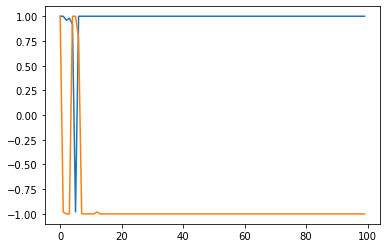

In [19]:
plt.figure(1)
plt.plot(rewards1)
plt.plot(rewards2)
plt.show()

In [19]:
env1 = Kickenv1(0.03,0.01,0.7,0.01,1)
m11  = A2C(MlpPolicy, env1, verbose=0)
env2 = Kickenv2(0.03,0.01,0.7,0.01,1)
m12 = A2C(MlpPolicy, env2, verbose=0)

In [20]:
models1 = []
models2 = []
rewards1 = []
rewards2 = []

In [21]:
m11.save("models1")
m12.save("models2")

In [ ]:
for i in range(100):
    
    if i%50==0:
        models1.append(m11)
        models2.append(m12)
    m11  = A2C.load("models1",env = env1,verbose = 0)
    m11.learn(total_timesteps=1000)
    mean_reward1, std_reward1 = evaluate_policy(m11, env1, n_eval_episodes=100)
    m11.save("models1")
    print(f"mean_reward1:{mean_reward1:.2f} +/- {std_reward1:.2f}")
    
    m12 = A2C.load("models2", env = env2, verbose=0)
    m12.learn(total_timesteps=1000)
    mean_reward2, std_reward2 = evaluate_policy(m12, env2, n_eval_episodes=100)
    m12.save("models2")
    print(f"mean_reward2:{mean_reward2:.2f} +/- {std_reward2:.2f}")
    
    env1 = Kickenv1(0.03,0.01,0.7,0.01,m12)
    env2 = Kickenv2(0.03,0.01,0.7,0.01,m11)
    rewards1.append(mean_reward1)
    rewards2.append(mean_reward2)

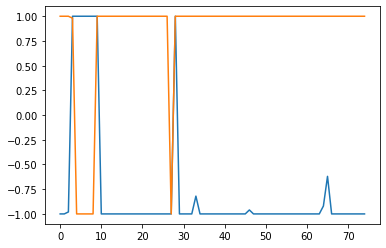

In [24]:
plt.figure(1)
plt.plot(rewards1[0:75])
plt.plot(rewards2[0:75])
plt.show()